In [217]:
!pip install gensim
import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem import SnowballStemmer
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import random
from tensorflow.keras import regularizers
import tensorflow as tf


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stemmer = SnowballStemmer("english")
word_embedder = api.load("glove-wiki-gigaword-100")

In [40]:
def euclidian_distance(vector1,vector2):
  return np.linalg.norm(vector1-vector2)

In [41]:
def similaridade_cosseno(vector1,vector2):
  return np.dot(vector1,vector2)/ np.sqrt(np.dot(vector1,vector1) * np.dot(vector2,vector2))

In [42]:
def get_wikiquote_quotes(page_title="John Doe", min_len=25, max_quotes=None):
    url = "https://en.wikiquote.org/w/api.php"
    session = requests.Session()
    headers = {
        "User-Agent": "Mozilla/5.0 (compatible; QuoteCollector/1.0; +https://example.com)"
    }

    params = {
        "action": "parse",
        "page": page_title,
        "prop": "text",
        "format": "json",
        "redirects": 1
    }

    r = session.get(url, params=params, headers=headers, timeout=30)

    if r.status_code != 200:
        raise RuntimeError(f"HTTP {r.status_code}\n{r.text[:300]}")

    ctype = r.headers.get("Content-Type", "")
    if "application/json" not in ctype and "json" not in ctype:
        raise RuntimeError(f"Resposta não-JSON (Content-Type: {ctype})\n{r.text[:300]}")

    data = r.json()

    if "error" in data:
        raise RuntimeError(f"API error: {data['error']}")

    html = data["parse"]["text"]["*"]
    soup = BeautifulSoup(html, "html.parser")

    items = soup.select("li")
    quotes = []
    for li in items:
        for sub in li.find_all(["ul", "ol"]):
            sub.decompose()

        text = " ".join(li.get_text(" ", strip=True).split())
        if len(text) < min_len:
            continue
        if text.lower().startswith(("see also", "external links", "references")):
            continue

        quotes.append(text)

    # Dedup
    quotes = list(dict.fromkeys(quotes))

    if max_quotes:
        quotes = quotes[:max_quotes]

    return quotes




In [47]:
plato_quotes = get_wikiquote_quotes("Plato")
descartes_quotes = get_wikiquote_quotes("René Descartes")

In [48]:
def remover_mencoes(quotes,name):
  quotes_nova = []
  for quote in quotes:
    if name not in quote:
      quotes_nova.append(quote)
  return quotes_nova


In [49]:
plato_quotes= remover_mencoes(plato_quotes,"Plato")
descartes_quotes  = remover_mencoes(descartes_quotes,"René Descartes")

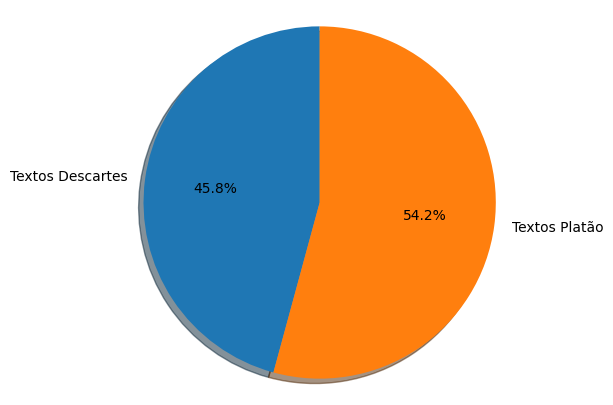

In [50]:
fig = plt.figure(figsize=(5, 5))

labels = 'Textos Descartes', 'Textos Platão'

sizes = [len(descartes_quotes), len(plato_quotes)]

plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.axis('equal')

plt.show()

## Tokenizar

In [51]:
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Remover Stopwords

In [52]:
import string
stopwords_english = stopwords.words('english')

print('Stop words\n')
print(stopwords_english[:10])

print('\nPunctuation\n')
print(string.punctuation)

Stop words

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

Punctuation

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


## Lowercase

É um padrão em modelos textuais transformar o texto em forma minúscula antes do processamento. Isso se dá pois palavras de diferentes formatos são lidas de formas diferentes pelo modelo, o que pode gerar resultados inesperados.



> Ex: "Oi" e "oi" podem, se não tratadas, ter frequências distintas, uma ocorrendo em reviews positivas e outra em negativas, o que não faz sentido.



In [53]:
def lowercase_frase(frase):
  frase_nova = []
  for palavra in frase:
    frase_nova.append(palavra.lower())
  return frase_nova

### Stopwords e Pontuações

Outra padronização feita é a remoção de **stopwords**, que nada mais são que palavras como artigos ou palavras que não incrementam no contexto textual e não são palavras-chave. Essa remoção é feita em casos em que sua presença não é vantajosa para a tarefa de classificação textual.

Como a comparação entre textos de ficção e de notícias têm o foco maior em palavras essenciais como substantivos, isso é uma tarefa vantajosa.

Para isso, bibliotecas como nltk oferecem uma lista de stopwords em diferentes linguagens, o que facilita o processo.

Da mesma forma, pontuações e outros símbolos como emojis também são removidos para evitar que o modelo se baseie de alguma forma neles para realizar a predição.

In [54]:
def remover_stopwords_frase(frase,stop_words):
  frase_nova = []
  for palavra in frase:
    if palavra not in stop_words:
      frase_nova.append(palavra)
  return frase_nova

In [55]:
def remove_pontuation_frase(frase):
  frase_nova = []
  pontuations = list(string.punctuation)
  pontuations.append("...")
  for palavra in frase:
      if palavra not in string.punctuation:
          frase_nova.append(palavra)

  return frase_nova

## Frequências de Palavras (Word by Document Design)

As frequências representam a soma das ocorrências de palavras previamente classificadas como alinhadas à ficção ou notícias dentro de um documento. Basicamente, o quão frequentemente uma dada palavra ocorre.


In [56]:
def preprocessar_textos(textos):
  textos_nova = []
  for frase in textos:
    frase = word_tokenize(frase)
    frase = lowercase_frase(frase)
    frase = remover_stopwords_frase(frase,stopwords_english)
    frase = remove_pontuation_frase(frase)
    textos_nova.append(frase)
  return textos_nova

In [57]:
def calcular_frequencia_palavras(textos):
  freq_palavras = Counter()
  palavras = []
  for frase in textos:
    print
    palavras = " ".join(frase).split()
    freq_palavras.update(palavras)
  return freq_palavras


In [59]:
plato_quotes_processed = preprocessar_textos(plato_quotes)
descartes_quotes_processed = preprocessar_textos(descartes_quotes)
frequencia_palavras_plato = calcular_frequencia_palavras(plato_quotes_processed)
frequencia_palavras_descartes = calcular_frequencia_palavras(descartes_quotes_processed)

In [61]:
print(len(frequencia_palavras_plato))
print(len(frequencia_palavras_descartes))

1721
2121


In [63]:
vocab = sorted(set(frequencia_palavras_plato) | set(frequencia_palavras_descartes))

def counter_to_vector(counter, vocab):
    return np.array([counter.get(w, 0) for w in vocab], dtype=np.float64)

v_plato = counter_to_vector(frequencia_palavras_plato, vocab)
v_descartes = counter_to_vector(frequencia_palavras_descartes, vocab)

In [64]:
euclidian_distance(v_plato,v_descartes)

np.float64(212.67345861672538)

In [65]:
similaridade_cosseno(v_plato,v_descartes)

np.float64(0.3996568991355157)

In [73]:
def plot_cosine_with_influential_words(
    v1, v2, vocab,
    label1="Platão", label2="Descartes",
    top_k=5,
    normalize_main_vectors=True,
    word_scale=0.35,
    alpha_words=0.35,
    figsize=(7, 7)
):

    v1 = np.asarray(v1, dtype=np.float64)
    v2 = np.asarray(v2, dtype=np.float64)

    n1 = np.linalg.norm(v1)
    n2 = np.linalg.norm(v2)


    u = v1 / n1
    v2_ortho = v2 - np.dot(v2, u) * u
    nv = np.linalg.norm(v2_ortho)

    if nv < 1e-12:
        e = np.zeros_like(v1)
        e[np.argmax(np.abs(u) < 0.9)] = 1.0
        v2_ortho = e - np.dot(e, u) * u
        nv = np.linalg.norm(v2_ortho)
        v = v2_ortho / nv
    else:
        v = v2_ortho / nv

    def coords_in_plane(x):
        return np.array([np.dot(x, u), np.dot(x, v)], dtype=np.float64)

    c1 = coords_in_plane(v1)
    c2 = coords_in_plane(v2)

    if normalize_main_vectors:
        c1 = c1 / np.linalg.norm(c1)
        c2 = c2 / np.linalg.norm(c2)

    contrib = v1 * v2
    top_idx = np.argsort(contrib)[::-1][:top_k]
    top_words = [vocab[i] for i in top_idx]
    top_scores = contrib[top_idx]

    fig, ax = plt.subplots(figsize=figsize)

    ax.axhline(0, linewidth=1)
    ax.axvline(0, linewidth=1)

    ax.quiver(0, 0, c1[0], c1[1], angles='xy', scale_units='xy', scale=1, width=0.012)
    ax.text(c1[0]*1.05, c1[1]*1.05, label1, fontsize=11)

    ax.quiver(0, 0, c2[0], c2[1], angles='xy', scale_units='xy', scale=1, width=0.012)
    ax.text(c2[0]*1.05, c2[1]*1.05, label2, fontsize=11)

    max_c = top_scores[0] if top_scores.size else 1.0
    for i in top_idx:
        ei_plane = np.array([u[i], v[i]], dtype=np.float64)
        norm_ei = np.linalg.norm(ei_plane)
        if norm_ei < 1e-12:
            continue
        ei_plane = ei_plane / norm_ei

        s = np.sqrt(max(contrib[i], 0.0) / max_c) * word_scale
        wvec = ei_plane * s

        ax.quiver(0, 0, wvec[0], wvec[1], angles='xy', scale_units='xy', scale=1,
                  alpha=alpha_words, width=0.008)
        ax.text(wvec[0]*1.15, wvec[1]*1.15, vocab[i], alpha=alpha_words, fontsize=9)

    cos_sim = float(np.dot(v1, v2) / (n1 * n2))
    ax.set_title(f"Similaridade de Cosseno = {cos_sim:.4f}")
    ax.set_aspect('equal', adjustable='box')

    all_x = [0, c1[0], c2[0]]
    all_y = [0, c1[1], c2[1]]
    lim = max(1.2, max(np.max(np.abs(all_x)), np.max(np.abs(all_y))) * 1.4)
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    plt.show()

    return top_words, top_scores

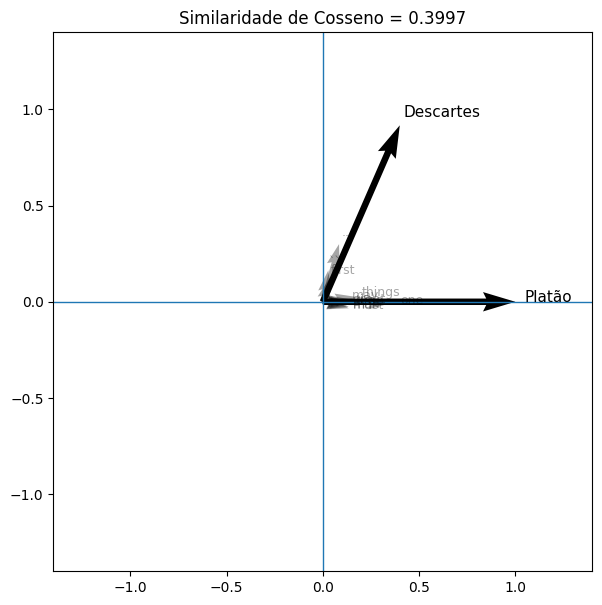

In [67]:
top_words, top_scores = plot_cosine_with_influential_words(
    v_plato, v_descartes, vocab,
    label1="Platão", label2="Descartes",
    top_k=10
)



## Augmentação dos dados

Tendo poucas frases dos dois filósofos, será feito uma augmentação de dados, onde basicamente palavras serão aleatoriamente removidas e um ruído obtido de uma distribuição normal será adicionado aos embeddings da frase

In [181]:
def augmentar_frase(frase, n_aug=3, drop_rate=0.2, noise_std=0.01):

    frases_aug = []

    if frase is None or len(frase) == 0:
        return frases_aug

    for _ in range(n_aug):
        nova_frase = [emb for emb in frase if random.random() > drop_rate]
        if len(nova_frase) == 0:
            nova_frase = frase

        nova_frase = [np.asarray(emb, dtype=np.float32) + np.random.normal(0, noise_std, size=np.asarray(emb).shape)
                      for emb in nova_frase]

        frases_aug.append(nova_frase)

    return frases_aug

def augmentar_dataset(frases, n_aug=3, drop_rate=0.2, noise_std=0.01):

    out = []
    for frase in frases:
        out.append(frase)
        out.extend(augmentar_frase(frase, n_aug=n_aug, drop_rate=drop_rate, noise_std=noise_std))
    return out

## Embeddings e MLP de classificação

Agora com transformando as palavras em embeddings, podemos então formar um vetor de embeddings representando os textos de Platão e René Descartes. Esse embedding, com 100 dimensões, pode, então, ser transformado em um embedding unidimensional, e uma frase inteira portanto vira um vetor de embeddings.

Esse vetor, de dimensão variante, pode ser reduzido para 512 dimensões com o PCA, e isso pode ser alimentado para uma MLP simples para uma classificação textual.

In [170]:
def transformar_embeddings_palavras(frase):
  vetor_embeddings_frase = []
  for palavra in frase:
    try:
      vetor_embeddings_frase.append(word_embedder[palavra])
    except KeyError:
      continue
  return vetor_embeddings_frase

In [221]:
plato_quotes_processed_embeddings = []
for frase in plato_quotes_processed:
  plato_quotes_processed_embeddings.append(transformar_embeddings_palavras(frase))

descartes_quotes_processed_embeddings = []
for frase in descartes_quotes_processed:
  descartes_quotes_processed_embeddings.append(transformar_embeddings_palavras(frase))

Para se ter uma ideia de como o PCA funciona, pegamos 2 vetores de frases aleatórias de Platão e Descartes e reduzimos cada palavra dentro delas para 2 dimensões, já é possível notar certa distinção. Isso por que o PCA trabalha tentando maximizar a variância dos dados, achando eigenvectors que transformam os dados sem mudar sua direção.

Shape original: (302, 100)
Variância explicada: [0.13414629 0.0610909 ]
Total explicado: 0.19523719


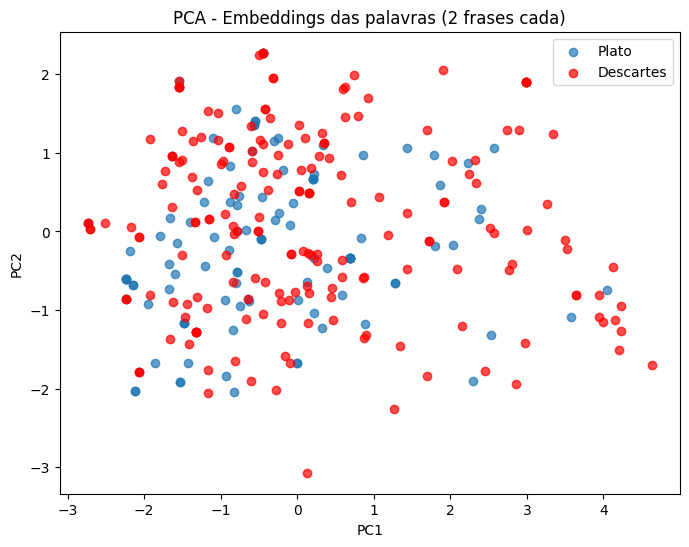

In [222]:
plato_f = plato_quotes_processed_embeddings[0:5]

descartes_f = descartes_quotes_processed_embeddings[0:5]

X = np.vstack(
    plato_f +
    descartes_f
)

print("Shape original:", X.shape)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

print("Variância explicada:", pca.explained_variance_ratio_)
print("Total explicado:", sum(pca.explained_variance_ratio_))

len_plato = sum(len(frase) for frase in plato_f)
len_descartes = sum(len(frase) for frase in descartes_f)

X_plato = X_2d[:len_plato]
X_descartes = X_2d[len_plato:len_plato+len_descartes]

plt.figure(figsize=(8,6))

plt.scatter(X_plato[:,0], X_plato[:,1], alpha=0.7, label="Plato")
plt.scatter(X_descartes[:,0], X_descartes[:,1], alpha=0.7, color='red', label="Descartes")

plt.legend()
plt.title("PCA - Embeddings das palavras (2 frases cada)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Shape original: (302, 100)
Variância explicada: [0.13414629 0.0610909  0.05738681]
Total explicado: 0.252624


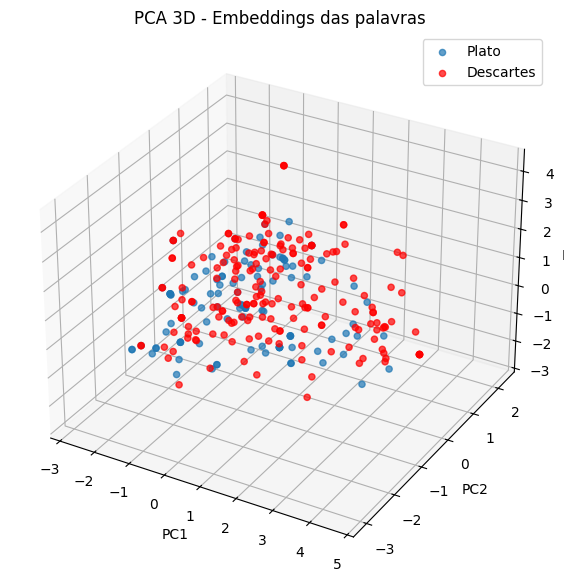

In [223]:
plato_f = plato_quotes_processed_embeddings[0:5]
descartes_f = descartes_quotes_processed_embeddings[0:5]

X = np.vstack([emb for frase in (plato_f + descartes_f) for emb in frase])

print("Shape original:", X.shape)

pca = PCA(n_components=3)
X_3d = pca.fit_transform(X)

print("Variância explicada:", pca.explained_variance_ratio_)
print("Total explicado:", sum(pca.explained_variance_ratio_))

len_plato = sum(len(frase) for frase in plato_f)
len_descartes = sum(len(frase) for frase in descartes_f)

X_plato = X_3d[:len_plato]
X_descartes = X_3d[len_plato:len_plato+len_descartes]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_plato[:,0], X_plato[:,1], X_plato[:,2],
           alpha=0.7, label="Plato")

ax.scatter(X_descartes[:,0], X_descartes[:,1], X_descartes[:,2],
           alpha=0.7, color='red', label="Descartes")

ax.set_title("PCA 3D - Embeddings das palavras")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

ax.legend()
plt.show()

### PCA para frases

Agora, com os vetores de embedddings de cada frase, é possível reduzir para apenas 64 dimensões, mesmo com uma perda considerável, isso fará possível representar as frases com dimensões padronizadas.
Primeiramente, temos que achatar os vetores individuais das palavras em uma frase para um único vetor para a frase, fazemos isso tirando as médias dos embeddings de cada palavra.

In [224]:
import numpy as np

def frase_para_vetor(frase, dim=100):
    if frase is None or len(frase) == 0:
        return np.zeros(dim, dtype=np.float32)

    M = np.asarray(frase, dtype=np.float32)

    if M.ndim == 1:
        if M.shape[0] == dim:
            return M
        else:
            return np.zeros(dim, dtype=np.float32)

    if M.shape[1] != dim:
        return np.zeros(dim, dtype=np.float32)

    return M.mean(axis=0)

In [225]:
frase_teste = plato_quotes_processed_embeddings[0]
frase_teste_comprimida = frase_para_vetor(frase_teste)
frase_teste_comprimida

array([ 0.2046198 , -0.10329799,  0.51506   ,  0.20341599, -0.2281406 ,
        0.6899384 , -0.592594  ,  0.29478982,  0.0826054 , -0.31999403,
        0.02713126,  0.116394  ,  0.47783262,  0.07029019, -0.050039  ,
       -0.4683884 ,  0.1557844 ,  0.42512003, -0.43798605,  0.38713   ,
       -0.21363199, -0.56703997, -0.24195595, -0.33519602, -0.111534  ,
        0.0266714 , -0.033298  , -0.0688726 ,  0.397368  , -0.46701398,
        0.3344248 ,  0.41896   , -0.0248918 , -0.144862  , -0.0628428 ,
        0.21041901,  0.3       , -0.120829  , -0.08434261, -0.23633102,
       -0.1824586 ,  0.10845599,  0.2058806 , -0.377196  , -0.2420468 ,
       -0.445674  ,  0.01005201, -0.0505766 , -0.289144  , -0.6596242 ,
        0.2921052 , -0.15016238,  0.1257378 ,  0.794384  ,  0.09633821,
       -1.209604  ,  0.2816376 , -0.4419228 ,  0.96540606,  0.040669  ,
        0.095198  ,  0.056481  , -0.3454658 , -0.2940536 ,  0.67159307,
        0.14031199,  0.01730349,  0.306022  , -0.23131399, -0.32

## Split de dados

Agora que os embeddings foram produzidos, é necessário fazer o split dos dados.
Esse será feito com as medidas padrões, com 80% dos dados reservados para treino e validação, e o restante teste. Além disso, é feito uma augmentação de dados com a função anteriormente feita para os dados de treino.

> Essa augmentação deve ser feita somente para o treino para evitar data leakage

Além disso, os embeddings são normalizados com um StandardScaler simples, resultando em cerca de 940 textos de treino e 40 de teste, todos com 64 dimensões.

In [227]:
plato_train, plato_test = train_test_split(
    plato_quotes_processed_embeddings,
    test_size=0.2,
    random_state=42
)

desc_train, desc_test = train_test_split(
    descartes_quotes_processed_embeddings,
    test_size=0.2,
    random_state=42
)


plato_train_aug = augmentar_dataset(plato_train, n_aug=5)
desc_train_aug  = augmentar_dataset(desc_train, n_aug=5)


X_train_raw = np.vstack(
    [frase_para_vetor(f) for f in plato_train_aug] +
    [frase_para_vetor(f) for f in desc_train_aug]
)

y_train = np.array(
    [0]*len(plato_train_aug) +
    [1]*len(desc_train_aug)
)

X_test_raw = np.vstack(
    [frase_para_vetor(f) for f in plato_test] +
    [frase_para_vetor(f) for f in desc_test]
)

y_test = np.array(
    [0]*len(plato_test) +
    [1]*len(desc_test)
)



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)



dim = 64
dim = min(dim, X_train_scaled.shape[1], X_train_scaled.shape[0])

pca = PCA(n_components=dim)
X_train = pca.fit_transform(X_train_scaled)
X_test  = pca.transform(X_test_scaled)

print("Shapes:", X_train.shape, X_test.shape)

Shapes: (955, 64) (41, 64)


## Treino do modelo MLP

Agora será feito o treino do modelo de rede neural que será alimentado com esses embeddings. É uma MLP simples de apenas 5 camadas, sendo 3 densas e 2 de dropout. Além disso, uma regularização L2 moderada é feita para evitar o overfitting com os dados.


In [233]:
tf.keras.backend.clear_session()

model = Sequential([
    Dense(
        64,
        activation='relu',
        input_shape=(X_train.shape[1],),
        kernel_regularizer=regularizers.l2(1e-2)
    ),
    Dropout(0.4),

    Dense(
        32,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-2)
    ),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,273 (24.50 KB)

 Trainable params: 6,273 (24.50 KB)

 Non-trainable params: 0 (0.00 B)

In [235]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9530 - loss: 0.3174 - val_accuracy: 0.8220 - val_loss: 0.5201
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9741 - loss: 0.2244 - val_accuracy: 0.8220 - val_loss: 0.5420
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9916 - loss: 0.1768 - val_accuracy: 0.8377 - val_loss: 0.4776
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9945 - loss: 0.1659 - val_accuracy: 0.8325 - val_loss: 0.5201
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9933 - loss: 0.1559 - val_accuracy: 0.8429 - val_loss: 0.4643
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9965 - loss: 0.1429 - val_accuracy: 0.8377 - val_loss: 0.4862
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9955 - loss: 0.1346 - val_accuracy: 0.8377 - val_loss: 0.5431
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9946 - loss: 0.1294 - val_accuracy: 0.8586 - val

## Predição de valores de teste

Agora podemos fazer a predição dos valores de teste armazenados anteriormente, como pode ver, o modelo possui uma acurácia de mais de 85% nesses valores, com uma perda que gira em torno dos 40%.

Para uma MLP simples e considerando as reduções que fizemos com PCA, é um resultado bastante bom que demonstra que a rede neural aprendeu e que há diferenças textuais significativas entre os filósofos.

In [237]:
model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8608 - loss: 0.4337


[0.4487669765949249, 0.8536585569381714]

In [241]:
def predizer_dados_teste(model, X_test, y_test):
    resultados = []
    predicoes = model.predict(X_test)
    for predicao in predicoes:
      if predicao >= 0.5:
        resultados.append("Descartes")
      else:
        resultados.append("Platão")
    reais = []
    for value in y_test:
      if value == 1:
        reais.append("Descartes")
      else:
        reais.append("Platão")
    return resultados,reais

In [242]:
resultados, reais = predizer_dados_teste(model, X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


## Visualizando com PCA

Com o PCA, podemos ainda pegar os resultados preditos pelo modelo e também os dados de teste, e, com um PCA, reduzir para 2 dimensões. O resultado é um mapeamento 2D que nos diz quão bem separados estão as representações textuais de acordo com as predições do modelo.
Pode-se ver que há uma separação mais notória, especialmente no eixo y, como pode-se ver pelos **Eigenvalues**.

Podemos comprovar isso reduzindo somente para a dimensão do eixo y. E como é possível ver pelo segundo gráfico, há uma clara separação entre textos de Descartes e Platão.


In [263]:
def visualizar_predicoes(model, X_test, resultados):

    pca_vis = PCA(n_components=2)
    X_2d = pca_vis.fit_transform(X_test)


    print("Eigenvalues")
    print("PC1:", pca_vis.explained_variance_[0])
    print("PC2:", pca_vis.explained_variance_[1])




    mask_plato = np.array(resultados) == 'Platão'
    mask_desc  = np.array(resultados) == 'Descartes'

    plt.figure(figsize=(8,6))

    plt.scatter(
        X_2d[mask_plato, 0],
        X_2d[mask_plato, 1],
        alpha=0.7,
        label="Pred: Platão"
    )

    plt.scatter(
        X_2d[mask_desc, 0],
        X_2d[mask_desc, 1],
        alpha=0.7,
        color='red',
        label="Pred: Descartes"
    )

    plt.legend()
    plt.title("Separação 2D")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

Eigenvalues
PC1: 30.35961
PC2: 10.157408


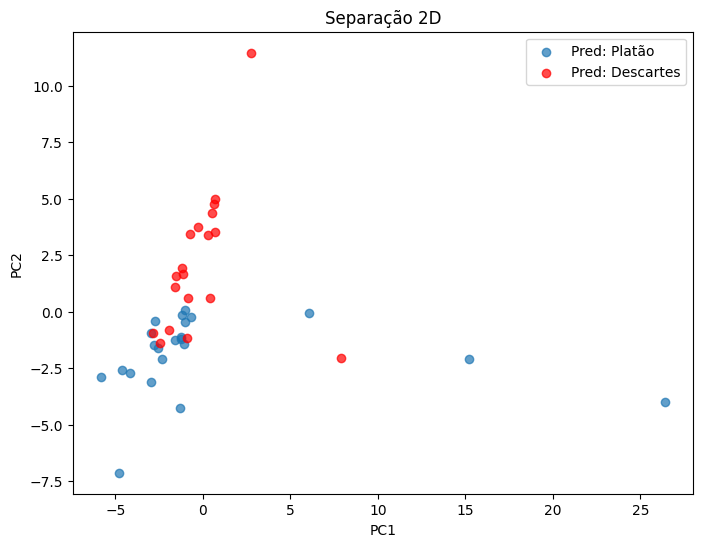

In [264]:
visualizar_predicoes(model, X_test, resultados)

In [260]:
def visualizar_1d_eixo_y(X_test, resultados):

    pca_vis = PCA(n_components=2)
    X_2d = pca_vis.fit_transform(X_test)

    eixo_y = X_2d[:, 1]

    mask_plato = np.array(resultados) == 'Platão'
    mask_desc  = np.array(resultados) == 'Descartes'

    plt.figure(figsize=(10,4))

    plt.scatter(
        eixo_y[mask_plato],
        np.zeros_like(eixo_y[mask_plato]),
        alpha=0.7,
        label="Platão"
    )

    plt.scatter(
        eixo_y[mask_desc],
        np.zeros_like(eixo_y[mask_desc]),
        alpha=0.7,
        color='red',
        label="Descartes"
    )

    plt.yticks([])
    plt.xlabel("PC2 (Eixo Y)")
    plt.title("Separação 1D")
    plt.legend()
    plt.show()

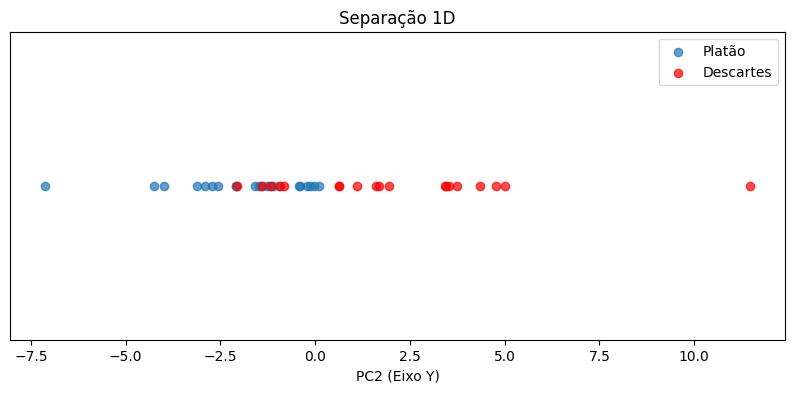

In [262]:
visualizar_1d_eixo_y(X_test, resultados)
